# MONTE CARLO SIMULATION OF STOCK PRICES

In [35]:
'''
import the various dependencies that will allow for this script to run 
as well as creating the class and initial variables we will need
'''
from pandas_datareader import data
import pandas as pd
import datetime
import numpy as np
import math
from scipy import stats
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

style.use('fivethirtyeight')
        
class monte_carlo:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        
    '''make two methods within our class, one for a single asset,
    and one for a portfolio of assets.'''     
    def get_asset(self, symbol):
        
        start = self.start 
        end = self.end 
        
        prices = data.DataReader(symbol, 'yahoo',start, end)['Adj Close']
        returns = prices.pct_change()
        
        self.returns = returns
        self.prices = prices
    
    def get_portfolio(self, symbols, weights):
        start = self.start
        end = self.end
        
        #Get Price Data
        df = data.DataReader(symbols, 'yahoo',start, end)['Adj Close']
        #Percent Change
        returns = df.pct_change()
        returns += 1
        
        #Define dollar amount in each asset
        port_val = returns * weights
        port_val['Portfolio Value'] = port_val.sum(axis=1)
        
        #Portfolio Dollar Values
        prices = port_val['Portfolio Value']
        
        #Portfolio Returns
        returns = port_val['Portfolio Value'].pct_change()
        returns = returns.replace([np.inf, -np.inf], np.nan)
                
        self.returns = returns
        self.prices = prices
        
    '''
    create a basic simulation that only uses the asset’s daily volatility, 
    while the other simulation will be using the concept of Geometric Brownian Motion.
    '''
    def monte_carlo_sim(self, num_simulations, predicted_days):
        returns = self.returns
        prices = self.prices
        
        last_price = prices[-1]
        
        simulation_df = pd.DataFrame()

        #Create Each Simulation as a Column in df
        for x in range(num_simulations):
            count = 0
            daily_vol = returns.std()
            
            price_series = []
            
            #Append Start Value
            price = last_price * (1 + np.random.normal(0, daily_vol))
            price_series.append(price)
            
            #Series for Preditcted Days
            for i in range(predicted_days):
                if count == 251:
                    break
                price = price_series[count] * (1 + np.random.normal(0, daily_vol))
                price_series.append(price)
                count += 1
        
            simulation_df[x] = price_series
            self.simulation_df = simulation_df
            self.predicted_days = predicted_days
            
    def brownian_motion(self, num_simulations, predicted_days):
        returns = self.returns
        prices = self.prices

        last_price = prices[-1]

        #Note we are assuming drift here
        simulation_df = pd.DataFrame()
        
        #Create Each Simulation as a Column in df
        for x in range(num_simulations):
            
            #Inputs
            count = 0
            avg_daily_ret = returns.mean()
            variance = returns.var()
            
            daily_vol = returns.std()
            daily_drift = avg_daily_ret - (variance/2)
            drift = daily_drift - 0.5 * daily_vol ** 2
            
            #Append Start Value    
            prices = []
            
            shock = drift + daily_vol * np.random.normal()
            last_price * math.exp(shock)
            prices.append(last_price)
            
            for i in range(predicted_days):
                if count == 251:
                    break
                shock = drift + daily_vol * np.random.normal()
                price = prices[count] * math.exp(shock)
                prices.append(price)
                
        
                count += 1
            simulation_df[x] = prices
            self.simulation_df = simulation_df
            self.predicted_days = predicted_days
            
    # create a line graph and histogram to visualize our data with Matplotlib.
    def line_graph(self):
        prices = self.prices
        predicted_days = self.predicted_days
        simulation_df = self.simulation_df
        
        last_price = prices[-1]
        fig = plt.figure(figsize=(12,8))
        style.use('bmh')
        
        title = "Monte Carlo Simulation: " + str(predicted_days) + " Days"
        plt.plot(simulation_df)
        fig.suptitle(title,fontsize=18, fontweight='bold')
        plt.xlabel('Day')
        plt.ylabel('Price ($USD)')
        plt.grid(True,color='grey')
        plt.axhline(y=last_price, color='r', linestyle='-')
        plt.show()
        

        #
    def histogram(self):
        simulation_df = self.simulation_df
        
        ser = simulation_df.iloc[-1, :]
        x = ser
        mu = ser.mean()
        sigma = ser.std()
        
        num_bins = 20
        # the histogram of the data
        n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='blue', alpha=0.5)
         
        # add a 'best fit' line
        y = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--')
        plt.xlabel('Price')
        plt.ylabel('Probability')
        plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')

        # Tweak spacing to prevent clipping of ylabel
        plt.subplots_adjust(left=0.15)
        plt.show()
        
    def VaR(self):
        
        '''
        we can actually calculate our theoretical Value at Risk with the given portfolio and simulation outputs. 
        The Value at Risk is simply the difference between the current price and specified price at a given confidence 
        interval.
        '''
        simulation_df = self.simulation_df
        prices = self.prices

        last_price = prices[-1]
        
        price_array = simulation_df.iloc[-1, :]
        price_array = sorted(price_array, key=int)  
        var =  np.percentile(price_array, 1)
        
        val_at_risk = last_price - var
        print("Value at Risk: ", val_at_risk)
        
        #Histogram
        fit = stats.norm.pdf(price_array, np.mean(price_array), np.std(price_array))
        plt.plot(price_array,fit,'-o')
        plt.hist(price_array,density=True)
        plt.xlabel('Price')
        plt.ylabel('Probability')
        plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')
        plt.axvline(x=var, color='r', linestyle='--', label='Price at Confidence Interval: ' + str(round(var, 2)))
        plt.axvline(x=last_price, color='k', linestyle='--', label = 'Current Stock Price: ' + str(round(last_price, 2)))
        plt.legend(loc="upper right")
        plt.show()
        
    # analyze the outputted simulations.  this can be done in a variety of ways.
    
    def key_stats(self):
        simulation_df = self.simulation_df

        print('#------------------Simulation Stats------------------#')
        count = 1
        for column in simulation_df:
            if count % 85 == 0:
                
                print("Simulation", count, "Mean Price: ", simulation_df[column].mean())
                print("Simulation", count, "Median Price: ", simulation_df[column].median())
            count += 1
        
        print('\n')
        
        print('#----------------------Last Price Stats--------------------#')
        print("Mean Price: ", np.mean(simulation_df.iloc[-1,:]))
        print("Maximum Price: ",np.max(simulation_df.iloc[-1,:]))
        print("Minimum Price: ", np.min(simulation_df.iloc[-1,:]))
        print("Standard Deviation: ",np.std(simulation_df.iloc[-1,:]))

        print('\n')
       
        print('#----------------------Descriptive Stats-------------------#')
        price_array = simulation_df.iloc[-1, :]
        print(price_array.describe())

        print('\n')
               
        print('#--------------Annual Expected Returns for Trials-----------#')
        count = 1
        future_returns = simulation_df.pct_change()
        for column in future_returns:
            if count % 85 == 0:
                
                print("Simulation", count, "Annual Expected Return", "{0:.2f}%".format((future_returns[column].mean() * 252) * 100))
                print("Simulation", count, "Total Return", "{0:.2f}%".format((future_returns[column].iloc[1] / future_returns[column].iloc[-1] - 1) * 100))
            count += 1     

        print('\n')
                         
        #Create Column For Average Daily Price Across All Trials
        simulation_df['Average'] = simulation_df.mean(axis=1)
        ser = simulation_df['Average']
        
        print('#----------------------Percentiles--------------------------------#')
        percentile_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
        for per in percentile_list:
            print("{}th Percentile: ".format(per), np.percentile(price_array, per))
        
        print('\n')
        
      #  print('#-----------------Calculate Probabilities-------------------------#')
       # print("Probability price is between 30 and 40: ",  "{0:.2f}%".format((float(len(price_array[(price_array&gt; 30) &amp; (price_array&lt;- 40)])) / float(len(price_array)) * 100))) 
       # print("Probability price is &gt; 45: ", "{0:.2f}%".format((float(len(price_array[price_array &gt; 45])) / float(len(price_array)))* 100))

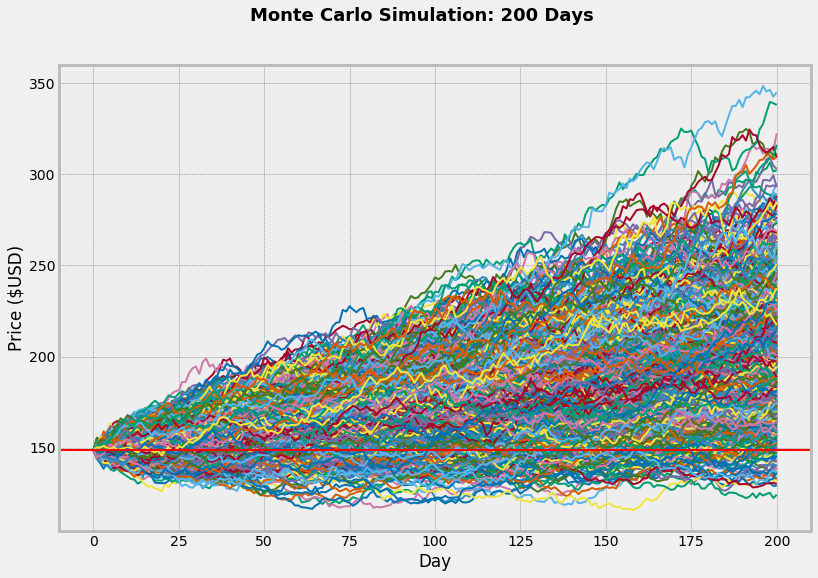

Value at Risk:  10.822245037618444


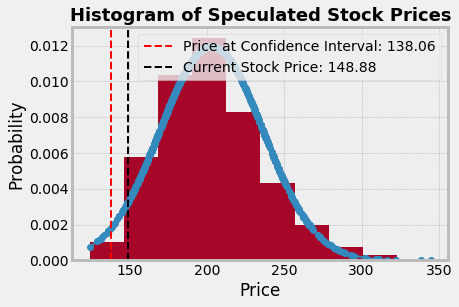

#------------------Simulation Stats------------------#
Simulation 85 Mean Price:  192.4778699935157
Simulation 85 Median Price:  201.98832494076737
Simulation 170 Mean Price:  206.37129406808947
Simulation 170 Median Price:  207.62889065009637
Simulation 255 Mean Price:  162.675458670012
Simulation 255 Median Price:  151.4417820878424
Simulation 340 Mean Price:  174.0057118760496
Simulation 340 Median Price:  155.38076746383712
Simulation 425 Mean Price:  162.14431178893557
Simulation 425 Median Price:  155.03899216213102
Simulation 510 Mean Price:  187.85331358268976
Simulation 510 Median Price:  192.5044517902678
Simulation 595 Mean Price:  182.48882698046248
Simulation 595 Median Price:  190.3039499440564
Simulation 680 Mean Price:  217.08811301748617
Simulation 680 Median Price:  206.5239498203164
Simulation 765 Mean Price:  158.09546806250032
Simulation 765 Median Price:  157.43201379900063
Simulation 850 Mean Price:  164.28384598057056
Simulation 850 Median Price:  157.6432457959

In [36]:
# Finally, to run the script:
if __name__== "__main__":

    start = datetime.datetime(2017, 1, 3)
    end = datetime.datetime(2017, 10, 4)
    
    sim = monte_carlo(start, end)

    #symbols = ['AAPL', 'KO', 'HD', 'PM']
    #weights = [1000,1000,2000,3000]
    
    #sim.get_portfolio(symbols, weights)
    sim.get_asset('AAPL')

    sim.brownian_motion(1000, 200)
    sim.line_graph()
    sim.VaR()
    sim.key_stats()